#### I. Referencias consultadas

# Numerical development to resolve Time-Dependent Schrödinger equation through eigenvalue problem

## 1. Import modules with useful functions, parameters, and algorithms.

In [1]:
name_code = "03_Code_auxiliary_tests";

In [2]:
include("../modules/module_schrodinger_equation_eigenproblem.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie`


## 2. Setting grid properties

* Tipo de grilla
* Discretización espacial
* Dominio
* Condiciones de contorno

In [3]:
Bohr_radius_meter=5.29177210903e−11;                        # [m]
Angstrom_to_meter=1e−10;                                    # [m/Å]
Angstrom_to_au=Angstrom_to_meter*(1.0/Bohr_radius_meter);   # [au/Å]

## 5. Resolve the 2D problem

### 5.1. Resolve eigenvalue problem

In [4]:
dom_2D=(-12.0*Angstrom_to_au,12.0*Angstrom_to_au,-4.9*Angstrom_to_au,4.9*Angstrom_to_au);   # cantidad de FE y dominio espacial
n_1D_r=50;n_1D_R=50;    # cantidad de FE por dimension (cantidad de intervalos)
ΔrH=abs(dom_2D[2]-dom_2D[1])/(n_1D_r-1); ΔRH=abs(dom_2D[4]-dom_2D[3])/(n_1D_R-1)                        # tamaño del elemento 2D
partition_2D=(n_1D_r,n_1D_R);                               # grilla de tamaño n²
model_2D=CartesianDiscreteModel(dom_2D,partition_2D);   # creamos modelo con elementos cartesianos

In [5]:
writevtk(model_2D,path_models*"CartesianDiscreteModel");

In [6]:
dirichlet_values_2D=(0.0+im*0.0);        # condiciones de contorno de tipo fulldirichlet
dirichlet_tags_2D="boundary";

In [7]:
Ω_2D,dΩ_2D,Γ_2D,dΓ_2D=measures(model_2D,3,dirichlet_tags_2D);
reffe_2D=ReferenceFE(lagrangian,Float64,2);
DOF_r,DOF_R,pts=space_coord_2D(dom_2D,ΔrH,ΔrH);

In [8]:
VHre_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
UHre_2D=TrialFESpace(VHre_2D,dirichlet_values_2D);

R₁=-5.0*Angstrom_to_au;R₂=5.0*Angstrom_to_au;Rc=1.5*Angstrom_to_au;Rf=1.5*Angstrom_to_au; # parameters

pH_2D,qH_2D,rH_2D=eigenvalue_problem_functions((R₁,R₂,Rc,Rf);switch_potential = "Electron_Nuclear_Potential_2D")
aH_2D,bH_2D=bilineal_forms(pH_2D,qH_2D,rH_2D,dΩ_2D);

Set Electron-Nuclear potential


In [9]:
nevH=4;
probH_2D=EigenProblem(aH_2D,bH_2D,UHre_2D,VHre_2D;nev=nevH,tol=10^(-9),maxiter=300,explicittransform=:none,sigma=-1.0);

In [10]:
ϵH_2D,ϕH_2D=solve(probH_2D);

In [11]:
# Escribimos autovectores para visualizar externamente
write_data=true;
if write_data
    for i in 1:nevH
        writevtk(Ω_2D,path_images*"eigenprob_2D_01_num$(i)",cellfields=["phi_real" => real(ϕH_2D[i]), "phi_imag" => imag(ϕH_2D[i])]);
    end
end

In [12]:
S_2D=TimeIndependet_Diff_Shannon_Entropy(ϕH_2D,UHre_2D,dΩ_2D)

4-element Vector{Float64}:
 5.229507640055694
 5.071584069225999
 5.033957129750414
 5.277693935203773

### 5.2. Resolve time-dependent Schrödinger equation

#### 5.2.1. Create initial condition

In [13]:
function gaussian_factor(x,R₀,β)
    return exp(-β*pow((x[2]-R₀),2));
end

function create_initial_state_2D(ϕₙ,n,Ω,dΩ,R₀,β)
    𝛹ₓ₀ = CellField(x->gaussian_factor(x,R₀,β),Ω)*ϕₙ[n];
    𝛹ₓ₀=𝛹ₓ₀*(1.0/norm_L2(𝛹ₓ₀,dΩ));
    return 𝛹ₓ₀;
end

create_initial_state_2D (generic function with 1 method)

In [14]:
𝛹ₓ₀=create_initial_state_2D(ϕH_2D,1,Ω_2D,dΩ_2D,-1.5*Angstrom_to_au,3.57*(1.0/(Angstrom_to_au*Angstrom_to_au)));

In [15]:
writevtk(Ω_2D,path_images*"initial_condition",cellfields=["real(𝛹ₓ₀)" =>real(𝛹ₓ₀),"imag(𝛹ₓ₀)" =>imag(𝛹ₓ₀)]);

#### 5.2.2. Time evolution

In [16]:
t_start=0.0;t_end=5000#8269;                      # tiempos adimensionales inicial y final
num_steps=t_end-1;                           # number of time steps or number of points  
n_int_save=round(Int,(num_steps-1)/20);     # Intervals where data is saved n_int_save=n_inf/numero=(num_steps-1)/numero
Δt=abs(t_end-t_start)*(1.0/(num_steps-1));   # time step

n_int_save2=round(Int,n_int_save/10);

time_vec=[t_start+Δt*(i-1) for i in 1:n_int_save2:num_steps];

In [25]:
𝛹ₓₜ=evolution_schrodinger(𝛹ₓ₀,ϕH_2D,ϵH_2D,UHre_2D,dΩ_2D,time_vec);

In [26]:
for i in 1:10:length(𝛹ₓₜ)
    writevtk(Ω_2D,path_images*"evolution_wave_function_$(lpad(i,3,'0'))",cellfields=["real(𝛹ₓₜ)" =>real(𝛹ₓₜ[i]),"imag(𝛹ₓₜ)" =>imag(𝛹ₓₜ[i])]);
end

### 5.3. Calculate entropy

In [29]:
function Partial_probability_density(𝛹ₓ,x₁,x₂,TrialSpace,Ω,dΩ)
    dim𝛹ₓ=length(𝛹ₓ);dimx₁=length(x₁);dimx₂=length(x₂);
    ρ_x₁_matrix=zeros(Float64,dimx₁,dim𝛹ₓ);
    ρ_x₂_matrix=zeros(Float64,dimx₂,dim𝛹ₓ);

    for t_index in 1:dim𝛹ₓ
        𝛹ₓᵢ=interpolate_everywhere(𝛹ₓ[t_index],TrialSpace);
        𝛹ₓᵢ=𝛹ₓᵢ/norm_L2(𝛹ₓᵢ,dΩ);
        ρₓᵢ=real(𝛹ₓᵢ'*𝛹ₓᵢ);

        for x₁_index in 1:dimx₁
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₁[x₁_index],1.0),Ω);
            δnorm=sum(integrate(δKroneckerGridap,dΩ));
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₁[x₁_index],δnorm),Ω);
            ρ_x₁_matrix[x₁_index,t_index]=sum(integrate(ρₓᵢ*δKroneckerGridap,dΩ))
        end

        for x₂_index in 1:dimx₂
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₂[x₂_index],1.0),Ω);
            δnorm=sum(integrate(δKroneckerGridap,dΩ));
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₂[x₂_index],δnorm),Ω);
            ρ_x₂_matrix[x₂_index,t_index]=sum(integrate(ρₓᵢ*δKroneckerGridap,dΩ))
        end
    end
    return ρ_x₁_matrix,ρ_x₂_matrix;
end

Partial_probability_density (generic function with 1 method)

In [30]:
electronic_ρ_matrix,nuclear_ρ_matrix=Partial_probability_density(𝛹ₓₜ,DOF_r,DOF_R,UHre_2D,Ω_2D,dΩ_2D);

In [548]:
# δKroneckerGridap = CellField(x->kronecker_deltax_Gridap_v2(x,DOF_r[1],1.0),Ω_2D);
# δnorm=sum(integrate(δKroneckerGridap,dΩ_2D));
# δKroneckerGridap = CellField(x->kronecker_deltax_Gridap_v2(x,DOF_r[1],δnorm),Ω_2D);

# writevtk(Ω_2D,path_images*"aux_function",cellfields=["δKroneckerGridap" =>δKroneckerGridap]);

In [31]:
function integration_argument_diff_shannon_entropy(ρ_x_value)
    return -ρ_x_value*log(ρ_x_value)
end

function Reduced_TimeIndependet_Diff_Shannon_Entropy(x_vec,function_x,ρ_x_vector)

    coef_vec=copy(x_vec);
    function_vec=copy(x_vec);
    dim_x=length(x_vec);

    coef_vec[1]=1.0;
    coef_vec[2:(dim_x-1)].=2.0;
    coef_vec[end]=1.0;

    function_vec[1]=function_x(ρ_x_vector[1]);
    function_vec[end]=function_x(ρ_x_vector[end]);

    for i in 2:(length(x_vec)-1);
        function_vec[i]=function_x(ρ_x_vector[i-1]);
    end

    Δx=abs(x_vec[2]-x_vec[1]);

    return 0.5*Δx*(transpose(function_vec)*coef_vec);
end

function Reduced_TimeDependent_Diff_Shannon_Entropy(reduced_ρ_matrix,DOF,function_DOF)
    S_vector=Vector{Float64}(undef,length(reduced_ρ_matrix[1,:]));
    for i in 1:length(S_vector)
        S_vector[i]=trapez1D_partial_integration(DOF,integration_argument_diff_shannon_entropy,reduced_ρ_matrix[:,i])
    end
    return S_vector;
end

Reduced_TimeDependent_Diff_Shannon_Entropy (generic function with 1 method)

In [42]:
total_S_2D=TimeIndependet_Diff_Shannon_Entropy(𝛹ₓₜ,UHre_2D,dΩ_2D);
electronic_S=Reduced_TimeDependent_Diff_Shannon_Entropy(electronic_ρ_matrix,DOF_r,integration_argument_diff_shannon_entropy);
nuclear_S=Reduced_TimeDependent_Diff_Shannon_Entropy(nuclear_ρ_matrix,DOF_R,integration_argument_diff_shannon_entropy);
mutual_info=total_S_2D.-electronic_S.-nuclear_S;

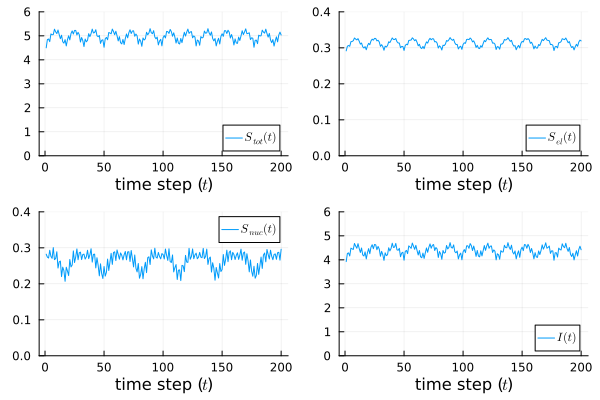

In [49]:
plot1=plot();
plot2=plot!(plot1,total_S_2D,label="\$S_{tot}(t)\$");
plot2=plot!(xlabel="time step (\$t\$)",ylim=(0,6))

plot3=plot();
plot4=plot!(plot3,electronic_S,label="\$S_{el}(t)\$");
plot4=plot!(xlabel="time step (\$t\$)",ylim=(0,0.4))

plot5=plot();
plot6=plot!(plot5,nuclear_S,label="\$S_{nuc}(t)\$");
plot6=plot!(xlabel="time step (\$t\$)",ylim=(0,0.4))

plot7=plot();
plot8=plot!(plot7,mutual_info,label="\$I(t)\$");
plot8=plot!(xlabel="time step (\$t\$)",ylim=(0,6))

plot3=plot(plot2,plot4,plot6,plot8,layout=(2,2));
display(plot3)